# Nodule classification with tabular data

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd

In [3]:
dp = Path("/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/processed/").absolute()
dp.exists()

True

In [4]:
RANDOM_SEED = 47

## Load data

In [82]:
data = pd.read_csv(dp/"meta/nodules.csv", index_col=["PatientID", "NoduleID"])
data.head()

StudyID  \
PatientID      NoduleID                                                      
LIDC-IDRI-0001 0         1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
LIDC-IDRI-0002 0         1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...   
LIDC-IDRI-0003 0         1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...   
               1         1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...   
               2         1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...   

                                                                  SeriesID  \
PatientID      NoduleID                                                      
LIDC-IDRI-0001 0         1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...   
LIDC-IDRI-0002 0         1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...   
LIDC-IDRI-0003 0         1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...   
               1         1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...   
               2         1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...   

                         NumAnnotations   Diameter  SurfaceArea       Volume  \
PatientID      NoduleID                                                        
LIDC-IDRI-0001 0                      4  32.755812  2491.466573  6989.673615   
LIDC-IDRI-0002 0                      2  30.781671  2807.198994  7244.667508   
LIDC-IDRI-0003 0                      1  31.664468  1996.252117  4731.410934   
               1                      4  31.001964  2225.677350  6519.463698   
               2                      4  13.309155   321.183599   472.089669   

                         Malignancy  Texture  Spiculation  Lobulation  ...  \
PatientID      NoduleID                                                ...   
LIDC-IDRI-0001 0                  5        5            5           3  ...   
LIDC-IDRI-0002 0                  5        2            1           1  ...   
LIDC-IDRI-0003 0                  2        1            1           1  ...   
               1                  5        4            3           2  ...   
               2                  4        5            2           2  ...   

                         Sphericity  Calcification  InternalStructure  \
PatientID      NoduleID                                                 
LIDC-IDRI-0001 0                  4              6                  1   
LIDC-IDRI-0002 0                  5              6                  1   
LIDC-IDRI-0003 0                  5              6                  1   
               1                  4              6                  1   
               2                  4              6                  1   

                         Subtlety  x_start  x_stop  y_start  y_stop  z_start  \
PatientID      NoduleID                                                        
LIDC-IDRI-0001 0                5      340     392      297     341       86   
LIDC-IDRI-0002 0                2      334     379      324     374      171   
LIDC-IDRI-0003 0                1      331     367      350     384       62   
               1                5      333     373      344     389       70   
               2                4      192     205      299     318       81   

                         z_stop  
PatientID      NoduleID          
LIDC-IDRI-0001 0             95  
LIDC-IDRI-0002 0            199  
LIDC-IDRI-0003 0             70  
               1             80  
               2             85  

[5 rows x 21 columns]

In [6]:
def load(path, index_cols=["PatientID", "NoduleID"], min_anns=3, exclude_labels=[3]):
    df = pd.read_csv(path, index_col=index_cols)
    df = df[df.NumAnnotations >= min_anns]
    df = df[~df.Malignancy.isin(exclude_labels)]
    return df

In [7]:
raw = load(dp/"meta/nodules.csv")
raw.shape

(747, 21)

## Preprocess data

In [8]:
def preprocess(data):
    data = data.drop(columns=["StudyID", 
                              "SeriesID", 
                              "NumAnnotations",
                              "x_start", 
                              "x_stop", 
                              "y_start",
                              "y_stop",
                              "z_start",
                              "z_stop"])
    feats, labels = data.drop(columns=["Malignancy"]), data["Malignancy"]
    labels = labels.transform(lambda x: x > 3).astype(int)
    return feats, labels

In [9]:
feats, labels = preprocess(raw)
print(feats.shape)
print(labels.shape)

(747, 11)
(747,)


In [10]:
labels.astype("category").describe()

count     747
unique      2
top         1
freq      443
Name: Malignancy, dtype: int64

## Train baseline model (decision tree)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [12]:
X_train, X_test, y_train, y_test = train_test_split(feats, labels, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)
print(X_train.shape)
print(X_test.shape)

(672, 11)
(75, 11)


In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [14]:
def evaluate(model, X, y):
    preds = model.predict(X)
    probs = model.predict_proba(X)[:, 1]
    print(f"Accuracy: {accuracy_score(y, preds):.4f}")
    print(f"AUC: {roc_auc_score(y, probs):.4f}")
    
def feature_importances(model, X):
    return pd.DataFrame(data={"feature": X.columns, "importance": model.feature_importances_}).sort_values("importance", ascending=False)

In [15]:
dt = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt.fit(X_train, y_train)
evaluate(dt, X_train, y_train)
evaluate(dt, X_test, y_test)

Accuracy: 1.0000
AUC: 1.0000
Accuracy: 0.9467
AUC: 0.9495


In [16]:
feature_importances(dt, X_train)

,feature,importance
0,Diameter,0.673969
8,Calcification,0.141970
2,Volume,0.052936
1,SurfaceArea,0.047078
6,Margin,0.018150
3,Texture,0.016632
4,Spiculation,0.016457
10,Subtlety,0.015869
7,Sphericity,0.013850
5,Lobulation,0.003088


## Train more complex model (random forest)

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
rf = RandomForestClassifier(random_state=RANDOM_SEED)
rf.fit(X_train, y_train)
evaluate(rf, X_train, y_train)
evaluate(rf, X_test, y_test)

Accuracy: 1.0000
AUC: 1.0000
Accuracy: 0.9467
AUC: 0.9895


In [19]:
feature_importances(rf, X_train)

,feature,importance
2,Volume,0.242362
0,Diameter,0.208688
1,SurfaceArea,0.164053
8,Calcification,0.140930
4,Spiculation,0.098574
5,Lobulation,0.057960
10,Subtlety,0.029908
7,Sphericity,0.025273
6,Margin,0.018646
3,Texture,0.013586


In [21]:
orig = pd.read_csv(dp/"meta/nodules.csv", index_col=["PatientID", "NoduleID"])
orig.shape

(2625, 21)

## Explain model

In [22]:
import shap

In [64]:
shap.initjs()

### Global explanation for test set

In [52]:
explainer = shap.Explainer(rf, output_names=["Benign", "Malignant"])

In [53]:
shap_values = explainer(X_test)

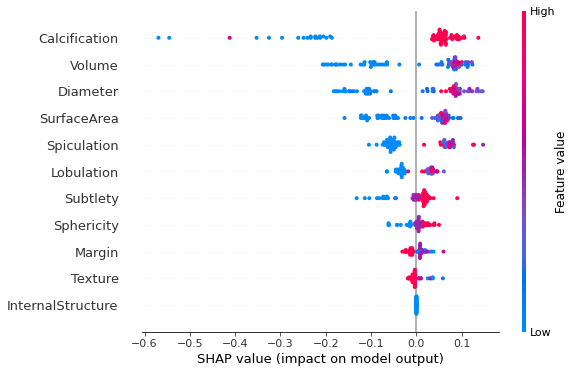

In [54]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=20)

### Local explanations for test case

In [87]:
X_case, y_case = preprocess(data.loc["LIDC-IDRI-0186"])
X_case

,Diameter,SurfaceArea,Volume,Texture,Spiculation,Lobulation,Margin,Sphericity,Calcification,InternalStructure,Subtlety
NoduleID,,,,,,,,,,,
0,5.714748,88.608536,87.238244,5,1,3,5,5,3,1,5
1,12.695788,412.727257,550.431778,1,1,1,2,5,6,1,1
2,6.485468,100.715517,90.353896,5,2,3,3,4,6,1,4
3,31.353731,3097.289971,7943.094052,5,4,3,3,4,6,4,5
4,17.445504,881.249009,1382.700205,5,4,3,4,4,6,1,5


In [94]:
y_case.loc[0]

0

In [89]:
shap_values_case = explainer(X_case)
shap_values_case.shape

(5, 11, 2)

In [91]:
import matplotlib.pyplot as plt

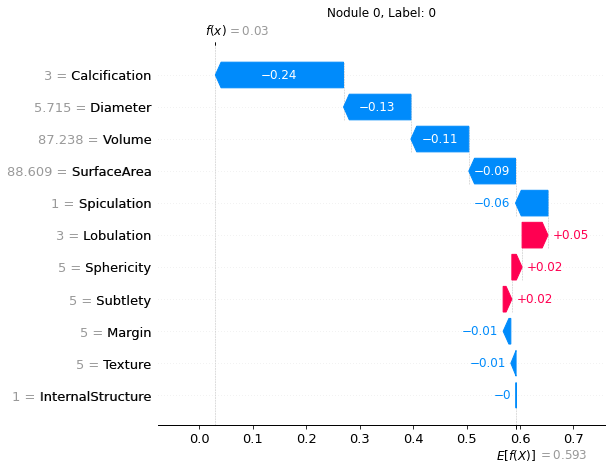

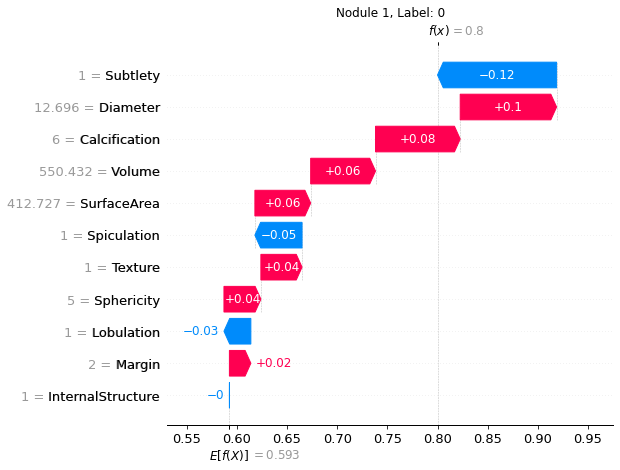

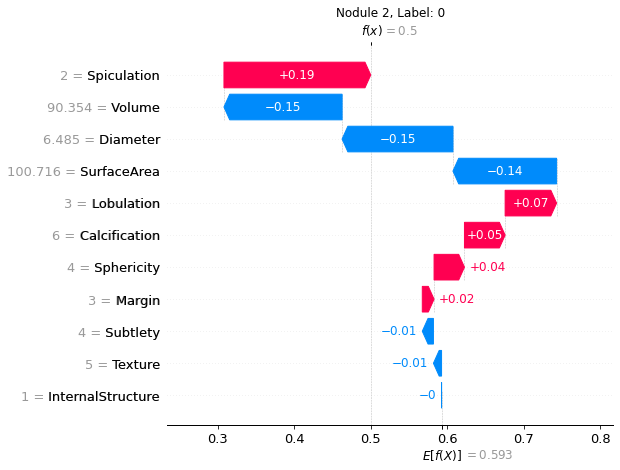

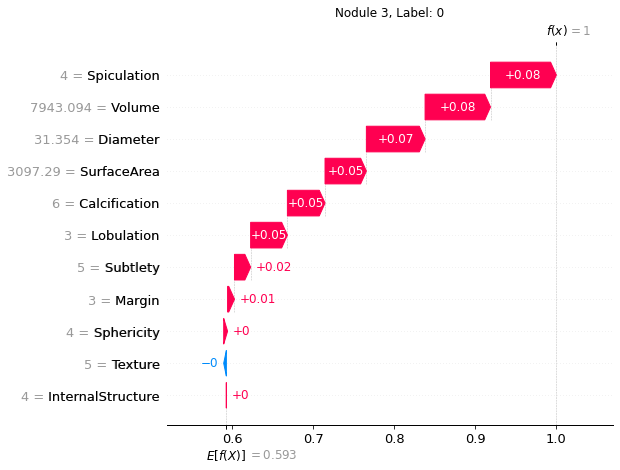

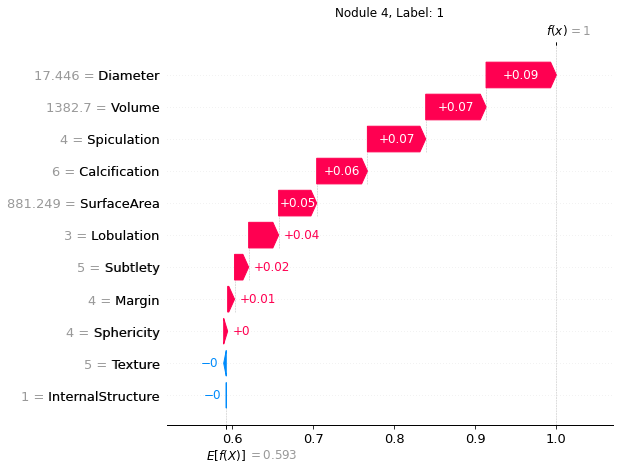

In [95]:
for i in range(shap_values_case.shape[0]):
    shap.plots.waterfall(shap_values_case[i, :, 1], max_display=20, show=False)
    plt.title(f"Nodule {i}, Label: {y_case.loc[i]}")
    plt.show()